# Dynamic Flux Balance Analysis (dFBA) in COBRApy

The following notebook shows a simple, but slow example of implementing dFBA using COBRApy and [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). This notebook shows a static optimization approach (SOA) implementation and should not be considered production ready.

The model considers only basic Michaelis-Menten limited growth on glucose.

In [1]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

Create or load a cobrapy model. Here, we use the 'textbook' e-coli core model.

In [2]:
import cobra
from cobra.io import load_model
model = load_model('textbook')

## Set up the dynamic system

Dynamic flux balance analysis couples a dynamic system in external cellular concentrations to a pseudo-steady state metabolic model.

In this notebook, we define the function `add_dynamic_bounds(model, y)` to convert the external metabolite concentrations into bounds on the boundary fluxes in the metabolic model.

In [7]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species
    
    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'max'])
    
    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass
    
    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))
        
    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.
    
    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.
    
    """
    
    with model:
        
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        
    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

## Run the dynamic FBA simulation

In [4]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 5.804: : 185it [00:16, 11.27it/s]


Because the culture runs out of glucose, the simulation terminates early. The exact time of this 'cell death' is recorded in `sol.t_events`.

In [5]:
sol

  message: 'A termination event occurred.'
     nfev: 179
     njev: 2
      nlu: 14
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.15151515, 0.3030303 , 0.45454545, 0.60606061,
       0.75757576, 0.90909091, 1.06060606, 1.21212121, 1.36363636,
       1.51515152, 1.66666667, 1.81818182, 1.96969697, 2.12121212,
       2.27272727, 2.42424242, 2.57575758, 2.72727273, 2.87878788,
       3.03030303, 3.18181818, 3.33333333, 3.48484848, 3.63636364,
       3.78787879, 3.93939394, 4.09090909, 4.24242424, 4.39393939,
       4.54545455, 4.6969697 , 4.84848485, 5.        , 5.15151515,
       5.3030303 , 5.45454545, 5.60606061, 5.75757576])
 t_events: [array([5.80191035])]
        y: array([[ 0.1       ,  0.10897602,  0.11871674,  0.12927916,  0.14072254,
         0.15310825,  0.16649936,  0.18095988,  0.19655403,  0.21334507,
         0.23139394,  0.25075753,  0.27148649,  0.29362257,  0.31719545,
         0.34221886,  0.36868605,  0.3965646 ,  0.42579062,  0.4562623 

### Plot timelines of biomass and glucose

Text(0, 0.5, 'Glucose')

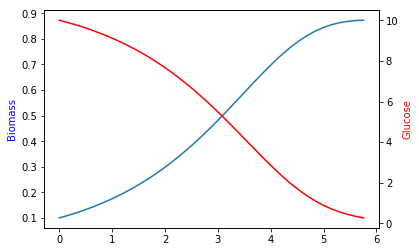

In [6]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')